----
# Металлургический комбинат ООО «Так закаляем сталь»
----

# Условие задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

<br>
<font size='5'><b> Описание этапа обработки</b></font>

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).


<br>
<font size='5'><b> Описание данных</b></font>

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).


Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

Данные также находятся в тренажёре, в папке /datasets/final_steel/.

-----

# Краткий план работы над проектом


- Загрузить и изучить данные, провести исследовательский анализ
- Привести данные к рабочему формату
- провести предобработку данных по замеру температур и вывести первую и последнюю 
- Вычленить только необходимые для работы данные и объеденить их в одну таблицу по ключу `key`
- Проверить ещё раз данные и заполнить или устранинить NAN
- Разделить выборки на тренировочную и тестовую
- Обучить несколько моделей регрессии и сравнить качество предсказаний
- Выбрать наилучшую модель с МАЕ < 6.0
- Объединить показатели метрик в одну сводную таблицу
- Составить отчёт о проделанной работе
---

## Загружаем библиотеки

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

## Загружаем данные

In [ ]:
#way = '/content/drive/MyDrive/Practicum/Финал/final_steel/'
way ='/datasets/final_steel/'

In [ ]:
data_arc = pd.read_csv(way+'data_arc.csv')
data_bulk = pd.read_csv(way+'data_bulk.csv')
data_bulk_time = pd.read_csv(way+'data_bulk_time.csv')
data_gas =pd.read_csv(way+'data_gas.csv')
data_temp =pd.read_csv(way+'data_temp.csv')
data_wire =pd.read_csv(way+'data_wire.csv')
data_wire_time =pd.read_csv(way+'data_wire_time.csv')

In [ ]:
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


In [ ]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [ ]:
data_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


In [ ]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [ ]:
data_bulk_time

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27


In [ ]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [ ]:
data_gas

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [ ]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [ ]:
data_temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


In [ ]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [ ]:
display(data_wire)
data_wire.info()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [ ]:
display(data_wire_time)
data_wire.info()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


----
## Выполним исследовательский анализ данных

### Приведём формат даты к формату `Datetime`

In [ ]:
data_arc['Начало нагрева дугой']=pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой']=pd.to_datetime(data_arc['Конец нагрева дугой'])
data_temp['Время замера']=pd.to_datetime(data_temp['Время замера'])

In [ ]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null datetime64[ns]
Конец нагрева дугой     14876 non-null datetime64[ns]
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [ ]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


## Посмотрим на распределение мощностей и отобразим их на одном графике

In [ ]:
sns.set_style('darkgrid')

### Для начала проверим выбросы в данных при помощи `boxplot`

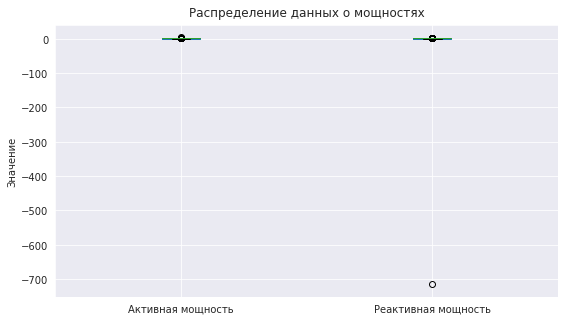

In [ ]:
plt.figure(figsize=(9,5))
data_arc.boxplot(['Активная мощность','Реактивная мощность'])
plt.title('Распределение данных о мощностях', y=1.01)
plt.ylabel('Значение')
plt.show()

### Удалим выбивающееся значение из нашей таблицы

In [ ]:
data_arc[data_arc['Реактивная мощность']<-100]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [ ]:
data_arc=data_arc[data_arc['Реактивная мощность']>-100]

### Посторим гистограммы распределения

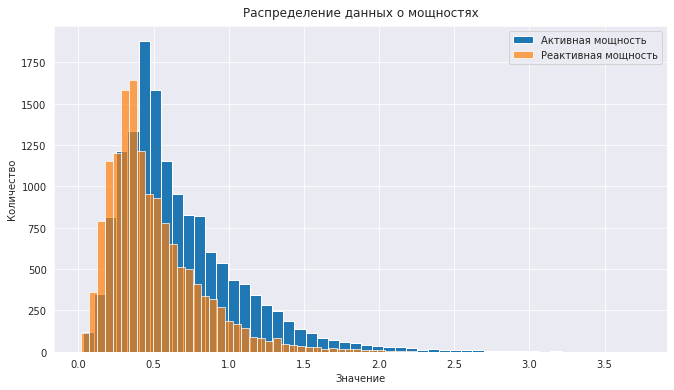

In [ ]:
plt.figure(figsize=(11,6))
data_arc['Активная мощность'].plot(kind='hist', bins=50, legend=True)
data_arc['Реактивная мощность'].plot(kind='hist', bins=50, legend=True, alpha=0.7)
plt.title('Распределение данных о мощностях', y=1.01)
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.show()

## Определим первую и последнюю замеры теператур

In [ ]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [ ]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null datetime64[ns]
Температура     13006 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


In [ ]:
data_temp_pivot = data_temp.pivot_table(index='key', aggfunc=['max','min'])
data_temp_pivot=data_temp_pivot.reset_index()
data_temp_pivot.columns=['key','Время замера','Температура в конце замера','Время первого замера температуры','Температура в начале замера']
data_temp_pivot.head()

,key,Время замера,Температура в конце замера,Время первого замера температуры,Температура в начале замера
0,1,2019-05-03 11:30:39,1618.0,2019-05-03 11:16:18,1571.0
1,2,2019-05-03 11:59:12,1608.0,2019-05-03 11:37:27,1577.0
2,3,2019-05-03 12:34:57,1599.0,2019-05-03 12:13:17,1596.0
3,4,2019-05-03 12:59:25,1625.0,2019-05-03 12:52:57,1601.0
4,5,2019-05-03 13:36:01,1602.0,2019-05-03 13:23:19,1576.0


### Удалим столбец "Температура в конце замера", т.к. присвоенные данные по последнему замеру температуры не соответствуют своему времени если были допущены пропуски

In [ ]:
data_temp_pivot= data_temp_pivot.drop(columns=['Температура в конце замера'])
data_temp_pivot.head()

,key,Время замера,Время первого замера температуры,Температура в начале замера
0,1,2019-05-03 11:30:39,2019-05-03 11:16:18,1571.0
1,2,2019-05-03 11:59:12,2019-05-03 11:37:27,1577.0
2,3,2019-05-03 12:34:57,2019-05-03 12:13:17,1596.0
3,4,2019-05-03 12:59:25,2019-05-03 12:52:57,1601.0
4,5,2019-05-03 13:36:01,2019-05-03 13:23:19,1576.0


## Добавим температуру поcледнего замера по значению ключа и времени



In [ ]:
data_temp_pivot=data_temp_pivot.merge(data_temp, on=['key','Время замера'], how='left')
data_temp_pivot

,key,Время замера,Время первого замера температуры,Температура в начале замера,Температура
0,1,2019-05-03 11:30:39,2019-05-03 11:16:18,1571.0,1613.0
1,2,2019-05-03 11:59:12,2019-05-03 11:37:27,1577.0,1602.0
2,3,2019-05-03 12:34:57,2019-05-03 12:13:17,1596.0,1599.0
3,4,2019-05-03 12:59:25,2019-05-03 12:52:57,1601.0,1625.0
4,5,2019-05-03 13:36:01,2019-05-03 13:23:19,1576.0,1602.0
...,...,...,...,...,...
3211,3237,2019-08-31 23:05:43,2019-08-31 22:44:04,1569.0,NaN
3212,3238,2019-08-31 23:43:00,2019-08-31 23:30:31,1584.0,NaN
3213,3239,2019-09-01 02:24:15,2019-09-01 01:31:47,1598.0,NaN
3214,3240,2019-09-01 03:35:16,2019-09-01 02:39:01,1617.0,NaN


In [ ]:
data_temp_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 5 columns):
key                                 3216 non-null int64
Время замера                        3216 non-null datetime64[ns]
Время первого замера температуры    3216 non-null datetime64[ns]
Температура в начале замера         3216 non-null float64
Температура                         2477 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 150.8 KB


### Мы видим пропущенные значения в целевом столбце, такие данные лучше не заполнять средним или другим значением, по-этому удалим строки без замеренных данных по температуре

In [ ]:
data_temp_pivot=data_temp_pivot.dropna(subset=['Температура'])

In [ ]:
data_temp_pivot.columns = ['key', 'Время последнего замера температуры',
       'Время первого замера температуры', 'Температура в начале замера',
       'Температура в конце замера']
data_temp_pivot

,key,Время последнего замера температуры,Время первого замера температуры,Температура в начале замера,Температура в конце замера
0,1,2019-05-03 11:30:39,2019-05-03 11:16:18,1571.0,1613.0
1,2,2019-05-03 11:59:12,2019-05-03 11:37:27,1577.0,1602.0
2,3,2019-05-03 12:34:57,2019-05-03 12:13:17,1596.0,1599.0
3,4,2019-05-03 12:59:25,2019-05-03 12:52:57,1601.0,1625.0
4,5,2019-05-03 13:36:01,2019-05-03 13:23:19,1576.0,1602.0
...,...,...,...,...,...
2472,2495,2019-08-06 00:54:42,2019-08-06 00:35:45,1570.0,1591.0
2473,2496,2019-08-06 01:29:52,2019-08-06 01:02:54,1554.0,1591.0
2474,2497,2019-08-06 01:53:50,2019-08-06 01:41:53,1571.0,1589.0
2475,2498,2019-08-06 02:25:31,2019-08-06 02:03:49,1570.0,1594.0


### Выведем распределение значения целевого признака на график

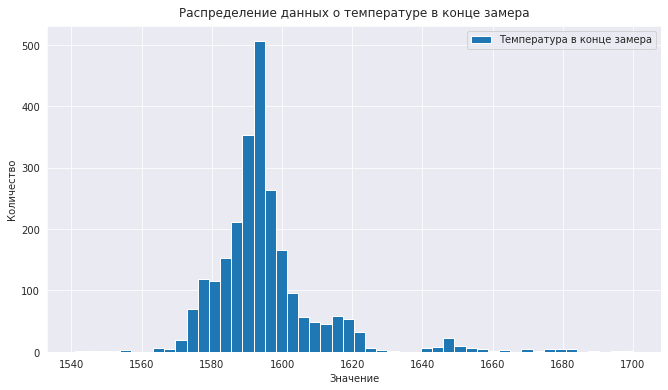

In [ ]:
plt.figure(figsize=(11,6))
data_temp_pivot['Температура в конце замера'].plot(kind='hist', bins=50, legend=True)
plt.title('Распределение данных о температуре в конце замера', y=1.01)
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.show()

## Посмотрим визульно на распределение данных в нашей таблице при помощи `pairplot`

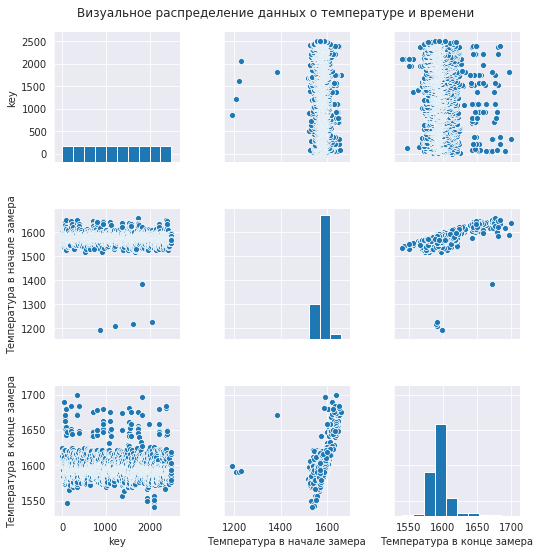

In [ ]:
sns.pairplot(data_temp_pivot, diag_kind="hist")
plt.suptitle("Визуальное распределение данных о температуре и времени", y=1.02, fontsize=12)
plt.show()

> На графике хорошо видно, что по каждому значению "key" температура в начале замера находится примерно в одном диапазоне, а в конце диапазон уже намного шире с наличием выбивающихся значений.

------
------

# Дополнительно для каждого значения столбца key найдём:

1. Длительность времени между первым и последним замером температуры.
2. Суммарное время нагрева электродами, то есть сумму значений по всем промежуткам между запусками нагрева электродов.
3. Количество запусков нагрева электродами.
4. Среднее соотношение потребления активной и реактивной мощности.<br>
По всем полученным столбцам вычислим статистики: средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей.

# p1. Длительность времени между первым и последним замером температуры.

In [ ]:
first_last_temp=data_temp.groupby('key')['Время замера'].agg({max,min})
first_last_temp=first_last_temp.reset_index()
first_last_temp.columns=['key', 'Время последнего замера температуры','Время первого замера температуры']
first_last_temp

,key,Время последнего замера температуры,Время первого замера температуры
0,1,2019-05-03 11:30:39,2019-05-03 11:16:18
1,2,2019-05-03 11:59:12,2019-05-03 11:37:27
2,3,2019-05-03 12:34:57,2019-05-03 12:13:17
3,4,2019-05-03 12:59:25,2019-05-03 12:52:57
4,5,2019-05-03 13:36:01,2019-05-03 13:23:19
...,...,...,...
3211,3237,2019-08-31 23:05:43,2019-08-31 22:44:04
3212,3238,2019-08-31 23:43:00,2019-08-31 23:30:31
3213,3239,2019-09-01 02:24:15,2019-09-01 01:31:47
3214,3240,2019-09-01 03:35:16,2019-09-01 02:39:01


### Оперделим длительность времени между первым и последним замером температуры.

In [ ]:
first_last_temp['Длительность между замерами температур'] = first_last_temp['Время последнего замера температуры'] - first_last_temp['Время первого замера температуры']
first_last_temp

,key,Время последнего замера температуры,Время первого замера температуры,Длительность между замерами температур
0,1,2019-05-03 11:30:39,2019-05-03 11:16:18,00:14:21
1,2,2019-05-03 11:59:12,2019-05-03 11:37:27,00:21:45
2,3,2019-05-03 12:34:57,2019-05-03 12:13:17,00:21:40
3,4,2019-05-03 12:59:25,2019-05-03 12:52:57,00:06:28
4,5,2019-05-03 13:36:01,2019-05-03 13:23:19,00:12:42
...,...,...,...,...
3211,3237,2019-08-31 23:05:43,2019-08-31 22:44:04,00:21:39
3212,3238,2019-08-31 23:43:00,2019-08-31 23:30:31,00:12:29
3213,3239,2019-09-01 02:24:15,2019-09-01 01:31:47,00:52:28
3214,3240,2019-09-01 03:35:16,2019-09-01 02:39:01,00:56:15


# p2. Суммарное время нагрева электродами, то есть сумму значений по всем промежуткам между запусками нагрева электродов.

In [ ]:
p2 = data_arc.copy()
p2['Время нагрева электродами'] = p2['Конец нагрева дугой']-p2['Начало нагрева дугой']
p2

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева электродами
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,00:03:48
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,00:03:05
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,00:02:52
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,00:06:05
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,00:02:28
...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,00:02:37
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,00:03:00
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,00:03:04
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,00:00:57


### Найдём суммарное время нагрева электродами по каждому `key`

In [ ]:
time_per_key= p2.groupby('key')['Время нагрева электродами'].sum()
time_per_key=time_per_key.reset_index()
time_per_key.columns=['key','Суммарное время нагрева электродами']
time_per_key

,key,Суммарное время нагрева электродами
0,1,00:18:18
1,2,00:13:31
2,3,00:10:55
3,4,00:12:21
4,5,00:14:29
...,...,...
3209,3237,00:15:09
3210,3238,00:09:06
3211,3239,00:20:16
3212,3240,00:13:59


In [ ]:
print('Суммарное время нагрева электродами по всем позициям равно:',p2['Время нагрева электродами'].sum())

Суммарное время нагрева электродами по всем позициям равно: 29 days 13:21:08


# p3. Количество запусков нагрева электродами

In [ ]:
count_heating = p2.groupby('key')['Время нагрева электродами'].count()
count_heating=count_heating.reset_index()
count_heating.columns = ['key','Количество запусков нагрева электродами']
count_heating

,key,Количество запусков нагрева электродами
0,1,5
1,2,4
2,3,5
3,4,4
4,5,4
...,...,...
3209,3237,5
3210,3238,3
3211,3239,8
3212,3240,5


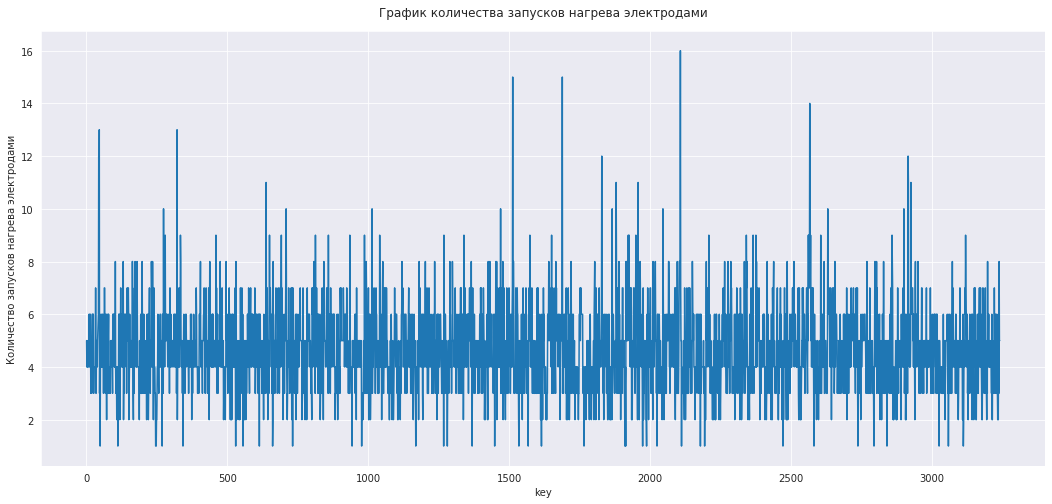

In [ ]:
plt.figure(figsize=(18,8))
sns.lineplot(data=count_heating, x='key',y='Количество запусков нагрева электродами')
plt.title('График количества запусков нагрева электродами', y=1.02)
plt.show()

In [ ]:
print('Суммарное количество запусков нагрева электродами равно:', count_heating['Количество запусков нагрева электродами'].sum())

Суммарное количество запусков нагрева электродами равно: 14875


# p4. Среднее соотношение потребления активной и реактивной мощности.

In [ ]:
mean_ratio_power = p2.groupby('key')['Активная мощность','Реактивная мощность'].mean()
mean_ratio_power = mean_ratio_power.reset_index()
mean_ratio_power.columns=['key','Средняя активная мощность','Сердняя реактивная мощность']
mean_ratio_power['Среднее отношение активной к реактивной мощности'] = mean_ratio_power['Средняя активная мощность']/mean_ratio_power['Сердняя реактивная мощность']
mean_ratio_power

,key,Средняя активная мощность,Сердняя реактивная мощность,Среднее отношение активной к реактивной мощности
0,1,0.975629,0.636648,1.532447
1,2,0.763150,0.499528,1.527741
2,3,0.505176,0.319815,1.579589
3,4,0.802313,0.515074,1.557663
4,5,0.836793,0.563161,1.485887
...,...,...,...,...
3209,3237,0.786493,0.565692,1.390321
3210,3238,0.702176,0.560394,1.253004
3211,3239,0.583344,0.388952,1.499784
3212,3240,0.596817,0.496653,1.201676


### Отобразим на графике

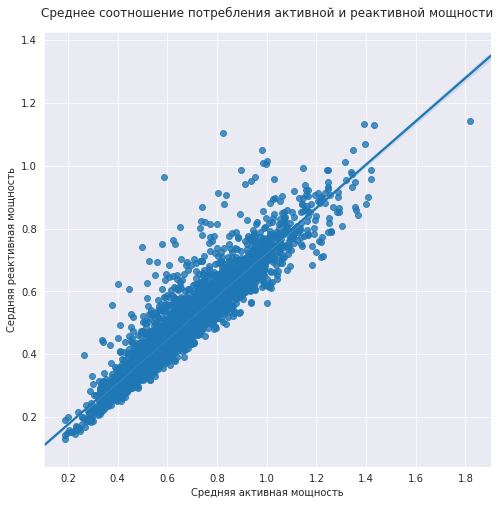

In [ ]:
plt.figure(figsize=(8,8))
sns.regplot(x="Средняя активная мощность", y="Сердняя реактивная мощность", data=mean_ratio_power)
plt.title('Среднее соотношение потребления активной и реактивной мощности',y=1.02)
plt.show()

## По всем полученным столбцам вычислим статистики: средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей.

###  - Для этого объеденим все полученные столбцы с основной таблицей

In [ ]:
table = time_per_key.merge(count_heating ,on='key')
table.head()

,key,Суммарное время нагрева электродами,Количество запусков нагрева электродами
0,1,00:18:18,5
1,2,00:13:31,4
2,3,00:10:55,5
3,4,00:12:21,4
4,5,00:14:29,4


In [ ]:
table = table.merge(mean_ratio_power ,on='key')
table.head()

,key,Суммарное время нагрева электродами,Количество запусков нагрева электродами,Средняя активная мощность,Сердняя реактивная мощность,Среднее отношение активной к реактивной мощности
0,1,00:18:18,5,0.975629,0.636648,1.532447
1,2,00:13:31,4,0.763150,0.499528,1.527741
2,3,00:10:55,5,0.505176,0.319815,1.579589
3,4,00:12:21,4,0.802313,0.515074,1.557663
4,5,00:14:29,4,0.836793,0.563161,1.485887


In [ ]:
table = table.merge(first_last_temp, on='key')
table.head()

,key,Суммарное время нагрева электродами,Количество запусков нагрева электродами,Средняя активная мощность,Сердняя реактивная мощность,Среднее отношение активной к реактивной мощности,Время последнего замера температуры,Время первого замера температуры,Длительность между замерами температур
0,1,00:18:18,5,0.975629,0.636648,1.532447,2019-05-03 11:30:39,2019-05-03 11:16:18,00:14:21
1,2,00:13:31,4,0.763150,0.499528,1.527741,2019-05-03 11:59:12,2019-05-03 11:37:27,00:21:45
2,3,00:10:55,5,0.505176,0.319815,1.579589,2019-05-03 12:34:57,2019-05-03 12:13:17,00:21:40
3,4,00:12:21,4,0.802313,0.515074,1.557663,2019-05-03 12:59:25,2019-05-03 12:52:57,00:06:28
4,5,00:14:29,4,0.836793,0.563161,1.485887,2019-05-03 13:36:01,2019-05-03 13:23:19,00:12:42


In [ ]:
table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 9 columns):
key                                                 3214 non-null int64
Суммарное время нагрева электродами                 3214 non-null timedelta64[ns]
Количество запусков нагрева электродами             3214 non-null int64
Средняя активная мощность                           3214 non-null float64
Сердняя реактивная мощность                         3214 non-null float64
Среднее отношение активной к реактивной мощности    3214 non-null float64
Время последнего замера температуры                 3214 non-null datetime64[ns]
Время первого замера температуры                    3214 non-null datetime64[ns]
Длительность между замерами температур              3214 non-null timedelta64[ns]
dtypes: datetime64[ns](2), float64(3), int64(2), timedelta64[ns](2)
memory usage: 251.1 KB


### Выведем средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей

In [ ]:
table.describe()

,key,Суммарное время нагрева электродами,Количество запусков нагрева электродами,Средняя активная мощность,Сердняя реактивная мощность,Среднее отношение активной к реактивной мощности,Длительность между замерами температур
count,3214.000000,3214,3214.000000,3214.000000,3214.000000,3214.000000,3214
mean,1623.061294,0 days 00:13:14.545115,4.628189,0.671067,0.501532,1.345269,0 days 00:30:41.006533
std,934.739859,0 days 00:05:32.491076,1.608866,0.207490,0.153933,0.135673,0 days 00:20:46.492873
min,1.000000,0 days 00:00:57,1.000000,0.186226,0.130062,0.609224,0 days 00:03:17
25%,817.250000,0 days 00:09:31,4.000000,0.519691,0.387213,1.277312,0 days 00:19:38.250000
50%,1623.500000,0 days 00:12:50,4.000000,0.646633,0.489478,1.357526,0 days 00:26:23
75%,2431.750000,0 days 00:16:23,6.000000,0.797201,0.599788,1.429244,0 days 00:37:15
max,3241.000000,0 days 01:09:49,16.000000,1.819169,1.141721,1.777119,0 days 06:32:17


----
----

## Объединим все интересующие нас данные в одну таблицу с учётом фильтра по последней замеренной температуре и добавим дополнительных данных о лигирующих присадках

In [ ]:
final_table=data_temp_pivot.merge(table, how='left', on=['key','Время последнего замера температуры','Время первого замера температуры'])
final_table

,key,Время последнего замера температуры,Время первого замера температуры,Температура в начале замера,Температура в конце замера,Суммарное время нагрева электродами,Количество запусков нагрева электродами,Средняя активная мощность,Сердняя реактивная мощность,Среднее отношение активной к реактивной мощности,Длительность между замерами температур
0,1,2019-05-03 11:30:39,2019-05-03 11:16:18,1571.0,1613.0,00:18:18,5.0,0.975629,0.636648,1.532447,00:14:21
1,2,2019-05-03 11:59:12,2019-05-03 11:37:27,1577.0,1602.0,00:13:31,4.0,0.763150,0.499528,1.527741,00:21:45
2,3,2019-05-03 12:34:57,2019-05-03 12:13:17,1596.0,1599.0,00:10:55,5.0,0.505176,0.319815,1.579589,00:21:40
3,4,2019-05-03 12:59:25,2019-05-03 12:52:57,1601.0,1625.0,00:12:21,4.0,0.802313,0.515074,1.557663,00:06:28
4,5,2019-05-03 13:36:01,2019-05-03 13:23:19,1576.0,1602.0,00:14:29,4.0,0.836793,0.563161,1.485887,00:12:42
...,...,...,...,...,...,...,...,...,...,...,...
2472,2495,2019-08-06 00:54:42,2019-08-06 00:35:45,1570.0,1591.0,00:12:03,4.0,0.802673,0.590194,1.360014,00:18:57
2473,2496,2019-08-06 01:29:52,2019-08-06 01:02:54,1554.0,1591.0,00:15:40,6.0,0.700511,0.468364,1.495654,00:26:58
2474,2497,2019-08-06 01:53:50,2019-08-06 01:41:53,1571.0,1589.0,00:09:29,3.0,0.737460,0.617090,1.195061,00:11:57
2475,2498,2019-08-06 02:25:31,2019-08-06 02:03:49,1570.0,1594.0,00:12:30,5.0,0.681745,0.471086,1.447179,00:21:42


### Добавим дополнительных данных о лигирующих присадках в общую таблицу

In [ ]:
data_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


In [ ]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


### Заполним пропущенные значения по каждому столбцу 'Bulk'

In [ ]:
bulk=data_bulk[['key','Bulk 12','Bulk 14','Bulk 15']]
#values={'Bulk 12': bulk['Bulk 12'].mean(), 'Bulk 14': bulk['Bulk 14'].mean(), 'Bulk 15': bulk['Bulk 15'].mean()}
bulk=bulk.fillna(value=0)
bulk

,key,Bulk 12,Bulk 14,Bulk 15
0,1,206.0,150.0,154.0
1,2,206.0,149.0,154.0
2,3,205.0,152.0,153.0
3,4,207.0,153.0,154.0
4,5,203.0,151.0,152.0
...,...,...,...,...
3124,3237,252.0,130.0,206.0
3125,3238,254.0,108.0,106.0
3126,3239,158.0,270.0,88.0
3127,3240,0.0,192.0,54.0


In [ ]:
bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 4 columns):
key        3129 non-null int64
Bulk 12    3129 non-null float64
Bulk 14    3129 non-null float64
Bulk 15    3129 non-null float64
dtypes: float64(3), int64(1)
memory usage: 97.9 KB


### Выберем из таблицы `data_wire` единственный заполненный столбец 'Wire 1' и заполним пропуски средним значением по столбцу

In [ ]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


#### Заполним данные по "wire"

In [ ]:
wire=data_wire[['key','Wire 1']]
wire=wire.fillna(0)
wire

,key,Wire 1
0,1,60.059998
1,2,96.052315
2,3,91.160157
3,4,89.063515
4,5,89.238236
...,...,...
3076,3237,38.088959
3077,3238,56.128799
3078,3239,143.357761
3079,3240,34.070400


### Добавим данные по проволоке из таблицы `wire` в финальную таблицу по ключу `key`

In [ ]:
final_table=final_table.merge(wire,on='key', how='left')
final_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 12 columns):
key                                                 2477 non-null int64
Время последнего замера температуры                 2477 non-null datetime64[ns]
Время первого замера температуры                    2477 non-null datetime64[ns]
Температура в начале замера                         2477 non-null float64
Температура в конце замера                          2477 non-null float64
Суммарное время нагрева электродами                 2475 non-null timedelta64[ns]
Количество запусков нагрева электродами             2475 non-null float64
Средняя активная мощность                           2475 non-null float64
Сердняя реактивная мощность                         2475 non-null float64
Среднее отношение активной к реактивной мощности    2475 non-null float64
Длительность между замерами температур              2475 non-null timedelta64[ns]
Wire 1                                             

### Добавим данные по присадкам из таблицы `bulk` в финальную таблицу по ключу `key`

In [ ]:
final_table=final_table.merge(bulk, on='key', how='left')
final_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 15 columns):
key                                                 2477 non-null int64
Время последнего замера температуры                 2477 non-null datetime64[ns]
Время первого замера температуры                    2477 non-null datetime64[ns]
Температура в начале замера                         2477 non-null float64
Температура в конце замера                          2477 non-null float64
Суммарное время нагрева электродами                 2475 non-null timedelta64[ns]
Количество запусков нагрева электродами             2475 non-null float64
Средняя активная мощность                           2475 non-null float64
Сердняя реактивная мощность                         2475 non-null float64
Среднее отношение активной к реактивной мощности    2475 non-null float64
Длительность между замерами температур              2475 non-null timedelta64[ns]
Wire 1                                             

### Добавим данные по охлаждению газом из таблицы `data_gas` в финальную таблицу по ключу `key`

In [ ]:
final_table=final_table.merge(data_gas, on='key', how='left')
final_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 16 columns):
key                                                 2477 non-null int64
Время последнего замера температуры                 2477 non-null datetime64[ns]
Время первого замера температуры                    2477 non-null datetime64[ns]
Температура в начале замера                         2477 non-null float64
Температура в конце замера                          2477 non-null float64
Суммарное время нагрева электродами                 2475 non-null timedelta64[ns]
Количество запусков нагрева электродами             2475 non-null float64
Средняя активная мощность                           2475 non-null float64
Сердняя реактивная мощность                         2475 non-null float64
Среднее отношение активной к реактивной мощности    2475 non-null float64
Длительность между замерами температур              2475 non-null timedelta64[ns]
Wire 1                                             

### Проверим наличие пропущенных значений `NAN` и удалим строки имеющие пропуски

In [ ]:
final_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 16 columns):
key                                                 2477 non-null int64
Время последнего замера температуры                 2477 non-null datetime64[ns]
Время первого замера температуры                    2477 non-null datetime64[ns]
Температура в начале замера                         2477 non-null float64
Температура в конце замера                          2477 non-null float64
Суммарное время нагрева электродами                 2475 non-null timedelta64[ns]
Количество запусков нагрева электродами             2475 non-null float64
Средняя активная мощность                           2475 non-null float64
Сердняя реактивная мощность                         2475 non-null float64
Среднее отношение активной к реактивной мощности    2475 non-null float64
Длительность между замерами температур              2475 non-null timedelta64[ns]
Wire 1                                             

In [ ]:
final_table=final_table.dropna()

### Вытащим из колонки "Суммарное время нагрева электродами", который находится в формате `timedelta` значение в секундах и добавим в финальную таблицу

In [ ]:
k=[]
for i in final_table['Суммарное время нагрева электродами']:
    y=i.total_seconds()
    k.append(y)
final_table['Время нагрева в секундах'] = k
final_table.head()

,key,Время последнего замера температуры,Время первого замера температуры,Температура в начале замера,Температура в конце замера,Суммарное время нагрева электродами,Количество запусков нагрева электродами,Средняя активная мощность,Сердняя реактивная мощность,Среднее отношение активной к реактивной мощности,Длительность между замерами температур,Wire 1,Bulk 12,Bulk 14,Bulk 15,Газ 1,Время нагрева в секундах
0,1,2019-05-03 11:30:39,2019-05-03 11:16:18,1571.0,1613.0,00:18:18,5.0,0.975629,0.636648,1.532447,00:14:21,60.059998,206.0,150.0,154.0,29.749986,1098.0
1,2,2019-05-03 11:59:12,2019-05-03 11:37:27,1577.0,1602.0,00:13:31,4.0,0.763150,0.499528,1.527741,00:21:45,96.052315,206.0,149.0,154.0,12.555561,811.0
2,3,2019-05-03 12:34:57,2019-05-03 12:13:17,1596.0,1599.0,00:10:55,5.0,0.505176,0.319815,1.579589,00:21:40,91.160157,205.0,152.0,153.0,28.554793,655.0
3,4,2019-05-03 12:59:25,2019-05-03 12:52:57,1601.0,1625.0,00:12:21,4.0,0.802313,0.515074,1.557663,00:06:28,89.063515,207.0,153.0,154.0,18.841219,741.0
4,5,2019-05-03 13:36:01,2019-05-03 13:23:19,1576.0,1602.0,00:14:29,4.0,0.836793,0.563161,1.485887,00:12:42,89.238236,203.0,151.0,152.0,5.413692,869.0


### Вытащим из колонки "Длительность между замерами температур", который находится в формате `timedelta` значение в секундах и добавим в финальную таблицу

In [ ]:
t=[]
for i in final_table['Длительность между замерами температур']:
    y=i.total_seconds()
    t.append(y)
final_table['Длительность между замерами температур секунды']=t
final_table.head()

,key,Время последнего замера температуры,Время первого замера температуры,Температура в начале замера,Температура в конце замера,Суммарное время нагрева электродами,Количество запусков нагрева электродами,Средняя активная мощность,Сердняя реактивная мощность,Среднее отношение активной к реактивной мощности,Длительность между замерами температур,Wire 1,Bulk 12,Bulk 14,Bulk 15,Газ 1,Время нагрева в секундах,Длительность между замерами температур секунды
0,1,2019-05-03 11:30:39,2019-05-03 11:16:18,1571.0,1613.0,00:18:18,5.0,0.975629,0.636648,1.532447,00:14:21,60.059998,206.0,150.0,154.0,29.749986,1098.0,861.0
1,2,2019-05-03 11:59:12,2019-05-03 11:37:27,1577.0,1602.0,00:13:31,4.0,0.763150,0.499528,1.527741,00:21:45,96.052315,206.0,149.0,154.0,12.555561,811.0,1305.0
2,3,2019-05-03 12:34:57,2019-05-03 12:13:17,1596.0,1599.0,00:10:55,5.0,0.505176,0.319815,1.579589,00:21:40,91.160157,205.0,152.0,153.0,28.554793,655.0,1300.0
3,4,2019-05-03 12:59:25,2019-05-03 12:52:57,1601.0,1625.0,00:12:21,4.0,0.802313,0.515074,1.557663,00:06:28,89.063515,207.0,153.0,154.0,18.841219,741.0,388.0
4,5,2019-05-03 13:36:01,2019-05-03 13:23:19,1576.0,1602.0,00:14:29,4.0,0.836793,0.563161,1.485887,00:12:42,89.238236,203.0,151.0,152.0,5.413692,869.0,762.0


In [ ]:
final_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2476
Data columns (total 18 columns):
key                                                 2329 non-null int64
Время последнего замера температуры                 2329 non-null datetime64[ns]
Время первого замера температуры                    2329 non-null datetime64[ns]
Температура в начале замера                         2329 non-null float64
Температура в конце замера                          2329 non-null float64
Суммарное время нагрева электродами                 2329 non-null timedelta64[ns]
Количество запусков нагрева электродами             2329 non-null float64
Средняя активная мощность                           2329 non-null float64
Сердняя реактивная мощность                         2329 non-null float64
Среднее отношение активной к реактивной мощности    2329 non-null float64
Длительность между замерами температур              2329 non-null timedelta64[ns]
Wire 1                                             

### Удалим колонки с форматами `timedelta` и `datetime` для использования нашей таблицы в моделях, а так же колонку `key`, т.к. она не несёт никаких бизнес-показателй для определения целевого признака

In [ ]:
model_fin_table=final_table.copy()
model_fin_table=model_fin_table.drop(columns=['key','Время последнего замера температуры','Время первого замера температуры','Суммарное время нагрева электродами','Длительность между замерами температур'])
model_fin_table.head()

,Температура в начале замера,Температура в конце замера,Количество запусков нагрева электродами,Средняя активная мощность,Сердняя реактивная мощность,Среднее отношение активной к реактивной мощности,Wire 1,Bulk 12,Bulk 14,Bulk 15,Газ 1,Время нагрева в секундах,Длительность между замерами температур секунды
0,1571.0,1613.0,5.0,0.975629,0.636648,1.532447,60.059998,206.0,150.0,154.0,29.749986,1098.0,861.0
1,1577.0,1602.0,4.0,0.763150,0.499528,1.527741,96.052315,206.0,149.0,154.0,12.555561,811.0,1305.0
2,1596.0,1599.0,5.0,0.505176,0.319815,1.579589,91.160157,205.0,152.0,153.0,28.554793,655.0,1300.0
3,1601.0,1625.0,4.0,0.802313,0.515074,1.557663,89.063515,207.0,153.0,154.0,18.841219,741.0,388.0
4,1576.0,1602.0,4.0,0.836793,0.563161,1.485887,89.238236,203.0,151.0,152.0,5.413692,869.0,762.0


In [ ]:
model_fin_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2476
Data columns (total 13 columns):
Температура в начале замера                         2329 non-null float64
Температура в конце замера                          2329 non-null float64
Количество запусков нагрева электродами             2329 non-null float64
Средняя активная мощность                           2329 non-null float64
Сердняя реактивная мощность                         2329 non-null float64
Среднее отношение активной к реактивной мощности    2329 non-null float64
Wire 1                                              2329 non-null float64
Bulk 12                                             2329 non-null float64
Bulk 14                                             2329 non-null float64
Bulk 15                                             2329 non-null float64
Газ 1                                               2329 non-null float64
Время нагрева в секундах                            2329 non-null float64
Длите

### Посмотрим на коррелирующие данные в нашей финальной таблице

In [ ]:
model_fin_table\
    .corr()\
    .style\
    .background_gradient(cmap='coolwarm')

,Температура в начале замера,Температура в конце замера,Количество запусков нагрева электродами,Средняя активная мощность,Сердняя реактивная мощность,Среднее отношение активной к реактивной мощности,Wire 1,Bulk 12,Bulk 14,Bulk 15,Газ 1,Время нагрева в секундах,Длительность между замерами температур секунды
Температура в начале замера,1,0.353292,-0.16609,-0.301215,-0.288873,-0.0302808,0.155272,-0.0352896,-0.0771676,0.0169947,-0.0481043,-0.285718,-0.0252831
Температура в конце замера,0.353292,1,0.181146,0.21107,0.149932,0.147833,0.317575,0.267424,0.114617,0.266414,0.0591602,0.278716,0.0974802
Количество запусков нагрева электродами,-0.16609,0.181146,1,0.0346963,0.0291182,0.0476153,0.13828,0.30723,0.333906,0.175047,0.403947,0.799038,0.587091
Средняя активная мощность,-0.301215,0.21107,0.0346963,1,0.92303,0.167139,-0.0959277,0.39238,0.350265,0.340881,0.0974972,0.562498,0.0732685
Сердняя реактивная мощность,-0.288873,0.149932,0.0291182,0.92303,1,-0.206861,-0.137593,0.376292,0.30879,0.300979,0.0725801,0.548072,0.0725531
Среднее отношение активной к реактивной мощности,-0.0302808,0.147833,0.0476153,0.167139,-0.206861,1,0.112812,0.0132549,0.114251,0.0705401,0.0710198,0.0492728,0.00481707
Wire 1,0.155272,0.317575,0.13828,-0.0959277,-0.137593,0.112812,1,0.170167,-0.0538355,0.118437,0.117313,0.0554951,0.164251
Bulk 12,-0.0352896,0.267424,0.30723,0.39238,0.376292,0.0132549,0.170167,1,0.481541,0.614479,0.217332,0.466789,0.220503
Bulk 14,-0.0771676,0.114617,0.333906,0.350265,0.30879,0.114251,-0.0538355,0.481541,1,0.265354,0.268889,0.461181,0.185683
Bulk 15,0.0169947,0.266414,0.175047,0.340881,0.300979,0.0705401,0.118437,0.614479,0.265354,1,0.0436237,0.295854,0.130262


> Из полученной таблицы можем видеть сильную коррелирующую зависимость двух мощностей (*активной* и *реактивной*), а так же *время нагрева в секундах* от *количества запусков нагрева электродами*, при дальнейшем обучении моделей на этих данных они могут мешать и модели могут давать неточные прогнозы. Но для того, чтобы понять какие данные стоит оставить, а какие нет мы посмотрим на *график важности* наилучшей модели.

---
## Определим тестовую и тренировочные выборки

In [ ]:
from sklearn.model_selection import train_test_split

###### Отделим целевой признак от наших данных

In [ ]:
X = model_fin_table.drop(columns='Температура в конце замера')
y = model_fin_table['Температура в конце замера']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

###### Проверим результат

In [ ]:
train_sample=X_train.shape[0]/X.shape[0]
test_sample=X_test.shape[0]/X.shape[0]

print('Размер тренировочной выборки- {:.0%}'.format(train_sample))
print('Размер тестовой выборки - {:.0%}'.format(test_sample))

Размер тренировочной выборки- 75%
Размер тестовой выборки - 25%


## Тестируем первую модель `DecisionTreeRegressor`

###### Загружаем метрики и модель

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

### Создадим функцию по выводу графика зависимости предсказанных от истинных значений и метрик качества предсказания

In [ ]:
def graph(name,predict):
    plt.figure(figsize=(8,8))
    sns.regplot(x=y_test, y=predict)
    plt.title('График распределения зависимости предсказанных от истинных значений', y=1.01)
    plt.ylabel('Предсказанные значения')
    plt.xlabel('Истинные значения')
    plt.show()

    print('Показание метрики MAE модели '+ name,': %.2f' % mean_absolute_error(y_test, predict))
    print('Показание метрики RMSE модели '+ name,': %.2f' % (mean_squared_error(y_test, predict))**0.5)
    print('Коэффициент детерминации  модели '+ name,': %.2f' % r2_score(y_test, predict))

In [ ]:
parametrs_r = { 'max_depth': range (1,10),
               'min_samples_leaf': range (1,5)}
model_d = DecisionTreeRegressor(random_state=12345)  
grid_dt = GridSearchCV(model_d, parametrs_r, cv=5, scoring='neg_mean_absolute_error')
grid_dt.fit(X_train,y_train)
best_score_dt = -1*grid_dt.best_score_
parametrs_dt = pd.Series(grid_dt.best_params_)[0]
predict_dt=grid_dt.predict(X_test)
print('Значение MAE на тренировочных данных равно: {:.2f}'.format(best_score_dt), '\nМаксимальная глубина:',parametrs_dt)


Значение MAE на тренировочных данных равно: 5.64 
Максимальная глубина: 7


In [ ]:
mae_dt= mean_absolute_error(y_test, predict_dt).round(2)
rmse_dt= (mean_squared_error(y_test, predict_dt)**0.5).round(2)
r2_dt= r2_score(y_test, predict_dt).round(2)

### Посмотрим на график и данные метрик

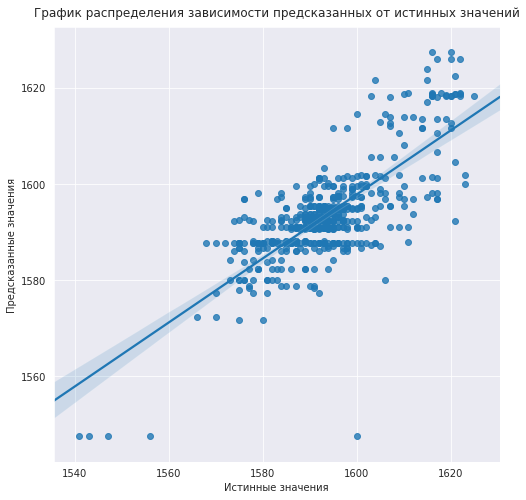

Показание метрики MAE модели DecisionTreeRegressor : 5.34
Показание метрики RMSE модели DecisionTreeRegressor : 7.51
Коэффициент детерминации  модели DecisionTreeRegressor : 0.57


In [ ]:
graph('DecisionTreeRegressor',predict_dt)

## Тестируем вторую модель `LinearRegression`

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
parametrs = { 'fit_intercept': [True],
              'normalize': [True, False]}

model_lr = LinearRegression()
grid_lr = GridSearchCV(model_lr, parametrs, cv=5, scoring='neg_mean_absolute_error')
grid_lr.fit(X_train,y_train)

fit_intercept=pd.Series(grid_lr.best_params_)[0]
normalize=pd.Series(grid_lr.best_params_)[1]
predict_lr=grid_lr.predict(X_test)
result_lr = -1*grid_lr.best_score_
print('значение MAE на тренировочных данных равно: {:.2f}'.format(result_lr), '\nfit_intercept:',fit_intercept, '\nnormalize:',normalize)

значение MAE на тренировочных данных равно: 5.74 
fit_intercept: True 
normalize: True


In [ ]:
mae_lr= mean_absolute_error(y_test, predict_lr).round(2)
rmse_lr= (mean_squared_error(y_test, predict_lr)**0.5).round(2)
r2_lr= r2_score(y_test, predict_lr).round(2)

### Посмотрим на график и данные метрик

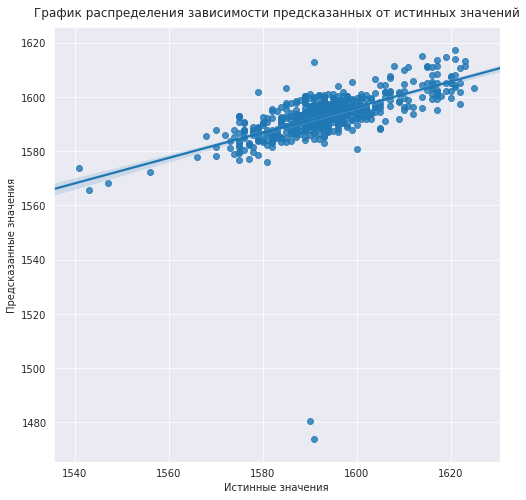

Показание метрики MAE модели LinearRegression : 6.06
Показание метрики RMSE модели LinearRegression : 10.04
Коэффициент детерминации  модели LinearRegression : 0.23


In [ ]:
graph('LinearRegression',predict_lr)

## Тестируем третью модель `CatBoostRegressor`

###### Выполним установку модели `CatBoostRegressor`

In [ ]:
!pip3 install catboost 

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
from catboost import CatBoostRegressor

In [ ]:
model = CatBoostRegressor(iterations=1000, depth=2, loss_function="MAE", verbose=100)
model.fit(X_train,y_train, eval_set=(X_test,y_test))

0:	learn: 7.9826966	test: 8.0485925	best: 8.0485925 (0)	total: 48.4ms	remaining: 48.4s
100:	learn: 5.8419697	test: 6.0838951	best: 6.0838951 (100)	total: 740ms	remaining: 6.59s
200:	learn: 5.2159361	test: 5.5162544	best: 5.5162544 (200)	total: 1.5s	remaining: 5.97s
300:	learn: 4.8821282	test: 5.2402821	best: 5.2402821 (300)	total: 2.26s	remaining: 5.25s
400:	learn: 4.6467281	test: 5.0458280	best: 5.0458280 (400)	total: 3.02s	remaining: 4.51s
500:	learn: 4.4768192	test: 4.9044549	best: 4.9044549 (500)	total: 3.78s	remaining: 3.77s
600:	learn: 4.3557880	test: 4.8329822	best: 4.8318419 (599)	total: 4.63s	remaining: 3.08s
700:	learn: 4.2530246	test: 4.7709688	best: 4.7709688 (700)	total: 5.39s	remaining: 2.3s
800:	learn: 4.1623438	test: 4.7213681	best: 4.7213681 (800)	total: 6.24s	remaining: 1.55s
900:	learn: 4.0826202	test: 4.6738675	best: 4.6738587 (899)	total: 7s	remaining: 769ms
999:	learn: 4.0196785	test: 4.6308379	best: 4.6305996 (990)	total: 7.75s	remaining: 0us

bestTest = 4.630599

### Посмотрим на график и данные метрик

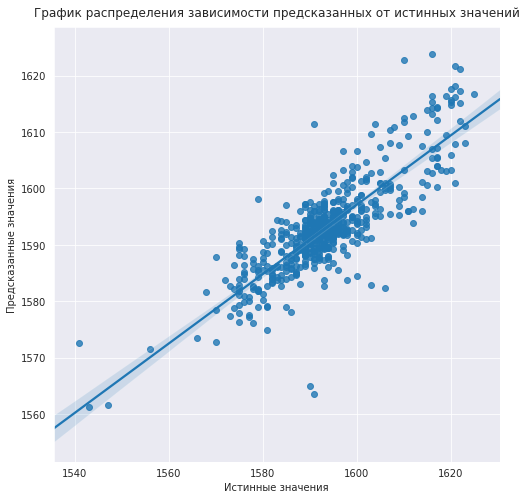

Показание метрики MAE модели CatBoostRegressor : 4.63
Показание метрики RMSE модели CatBoostRegressor : 6.43
Коэффициент детерминации  модели CatBoostRegressor : 0.69


In [ ]:
predict_cat=model.predict(X_test)
graph('CatBoostRegressor',predict_cat)

## Найдём факторы важности наилучшей модели

In [ ]:
def importances(model,features):
    features=features.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    plt.figure(figsize=(11, 5))
    plt.title('Важность функции')
    plt.barh(range(len(indices)), importances[indices], color='#6495ED', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Относительная важность')
    plt.show()
        
    feat_importances = pd.Series(importances, index=features).sort_values(ascending=False)
    feat_importances = feat_importances.to_frame()
    feat_importances.columns=['Относительная важность']
    display(feat_importances)

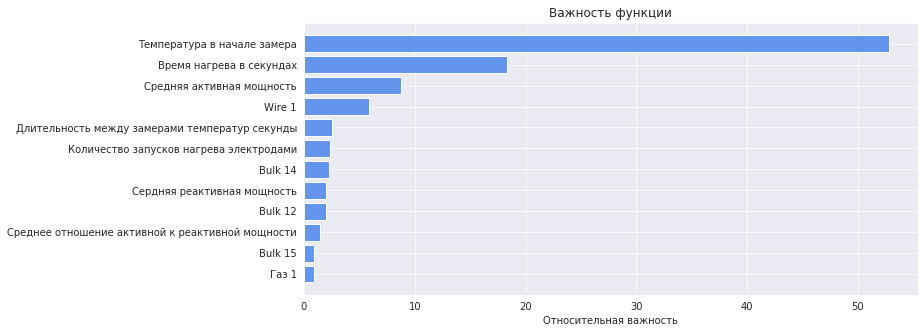

,Относительная важность
Температура в начале замера,52.761020
Время нагрева в секундах,18.281335
Средняя активная мощность,8.777744
Wire 1,5.826735
Длительность между замерами температур секунды,2.511171
Количество запусков нагрева электродами,2.326633
Bulk 14,2.229538
Сердняя реактивная мощность,2.031501
Bulk 12,1.988620
Среднее отношение активной к реактивной мощности,1.443527


In [ ]:
importances(model,X_test)

### Судя по распределению важности данных можем откинуть лишние данные - это `Газ 1` и сильно кореелирующую `Сердняя реактивная мощность`, т.к. `Средняя активная мощность	` имеет больший вес в предсказании данных

In [ ]:
X_train2 = X_train.copy()
X_test2= X_test.copy()
X_train2 = X_train2.drop(columns=['Газ 1', 'Сердняя реактивная мощность'])
X_test2= X_test2.drop(columns=['Газ 1', 'Сердняя реактивная мощность'])
X_train2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1746 entries, 1680 to 923
Data columns (total 10 columns):
Температура в начале замера                         1746 non-null float64
Количество запусков нагрева электродами             1746 non-null float64
Средняя активная мощность                           1746 non-null float64
Среднее отношение активной к реактивной мощности    1746 non-null float64
Wire 1                                              1746 non-null float64
Bulk 12                                             1746 non-null float64
Bulk 14                                             1746 non-null float64
Bulk 15                                             1746 non-null float64
Время нагрева в секундах                            1746 non-null float64
Длительность между замерами температур секунды      1746 non-null float64
dtypes: float64(10)
memory usage: 150.0 KB


### Проверим теперь эти данные на нашей моделе

0:	learn: 7.9771983	test: 8.0385068	best: 8.0385068 (0)	total: 1.98ms	remaining: 1.98s
100:	learn: 5.8104336	test: 6.0416209	best: 6.0416209 (100)	total: 626ms	remaining: 5.57s
200:	learn: 5.1908239	test: 5.4701809	best: 5.4701809 (200)	total: 1.47s	remaining: 5.84s
300:	learn: 4.8492898	test: 5.1802655	best: 5.1802655 (300)	total: 2.3s	remaining: 5.33s
400:	learn: 4.6009021	test: 4.9401029	best: 4.9401029 (400)	total: 2.97s	remaining: 4.44s
500:	learn: 4.4433071	test: 4.8165276	best: 4.8165276 (500)	total: 3.72s	remaining: 3.71s
600:	learn: 4.3227961	test: 4.7387417	best: 4.7387417 (600)	total: 4.49s	remaining: 2.98s
700:	learn: 4.2337958	test: 4.6865904	best: 4.6865904 (700)	total: 5.25s	remaining: 2.24s
800:	learn: 4.1440710	test: 4.6424763	best: 4.6424763 (800)	total: 6.01s	remaining: 1.49s
900:	learn: 4.0838616	test: 4.5962055	best: 4.5962055 (900)	total: 6.76s	remaining: 743ms
999:	learn: 4.0378820	test: 4.5650426	best: 4.5645135 (996)	total: 7.51s	remaining: 0us

bestTest = 4.56

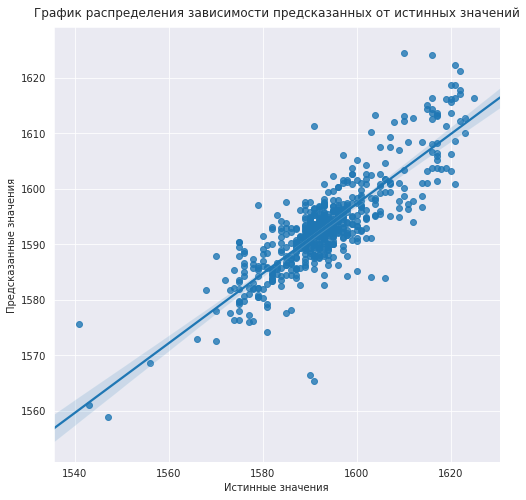

Показание метрики MAE модели CatBoostRegressor : 4.56
Показание метрики RMSE модели CatBoostRegressor : 6.31
Коэффициент детерминации  модели CatBoostRegressor : 0.70


In [ ]:
model = CatBoostRegressor(iterations=1000, depth=2, loss_function="MAE", verbose=100)
model.fit(X_train2,y_train, eval_set=(X_test2,y_test))
predict_cat=model.predict(X_test)
graph('CatBoostRegressor',predict_cat)

In [ ]:
mae_cat= mean_absolute_error(y_test, predict_cat).round(2)
rmse_cat= (mean_squared_error(y_test, predict_cat)**0.5).round(2)
r2_cat= r2_score(y_test, predict_cat).round(2)

## Подведём итоги предсказаний наших моделей и сведём данные в одну таблицу

In [ ]:
column=['Показание метрики MAE']
comparison_tabl = pd.DataFrame(index=['DecisionTreeRegressor','LinearRegression','CatBoostRegressor'], columns=['Показание метрики RMSE','Коэффициент детерминации R2','Показание метрики MAE'])
comparison_tabl['Показание метрики MAE'] = mae_dt,mae_lr,mae_cat
comparison_tabl['Показание метрики RMSE'] = rmse_dt,rmse_lr,rmse_cat
comparison_tabl['Коэффициент детерминации R2'] = r2_dt,r2_lr,r2_cat

comparison_tabl.style.highlight_min(color='yellowgreen',subset=column).highlight_null(null_color='lightgrey').highlight_max(color='coral',subset=column)

,Показание метрики RMSE,Коэффициент детерминации R2,Показание метрики MAE
DecisionTreeRegressor,7.51,0.57,5.34
LinearRegression,10.04,0.23,6.06
CatBoostRegressor,6.31,0.7,4.56


---
# Вывод

Мы постарились использовать максимальное количество данных из тех что предоставил заказчик и на этих данных обучили три модели `DecisionTreeRegressor`,`LinearRegression` и `CatBoostRegressor`. <br> По итогам сравнения метрик качества предсказаний из трёх моделей лидирует `CatBoostRegressor`, которая достигла значения в $4.56$ по метрике $MAE$ <br> Таким образом мы достигли требуемого значения $MAE <6.00$, а так же дополнительно выяснили наиболее важные данные на которых строилось предсказание нашей наилучшей модели, **ТОП-3** из которых это "*Температура в начале замера, Время нагрева в секундах и Средняя активная мощность*"

----
## Отчёт по решению

Перед нами стояла задача оптимизировать производственные расходы, металлургический комбинат **ООО «Так закаляем сталь»** на этапе обработки стали. Для этого нам предстояло построить модель, которая предскажет температуру стали в последней точке измерения имея данные о начальных температурах и количестве присадок, а так же времени их добавления и измерения температуры. При этом Целью поставлена метрика $MAE$ со значением $< 6.00$ 
<br>

В начальном плане были определены промежуточные этапы по-которому и строилось выполнение проекта. Самым основным и решающим значением было принято решение о добавлении в исходные данные новых признаков, на основе которых модель сможет лучше предсказывать целевое значение по темпратуре. Были добавлены дополнительные столбцы:
   - Длительность времени между первым и последним замером температуры.
   - Суммарное время нагрева электродами, то есть сумму значений по всем промежуткам между запусками нагрева электродов.
   - Количество запусков нагрева электродами.
   - Среднее соотношение потребления активной и реактивной мощности.
   

Для нахождения наилучего качества в предсказании мы обучили три модели `DecisionTreeRegressor`,`LinearRegression` и `CatBoostRegressor` и сравнили их показатели по трём метрикам $MAE$, $MSE$ и $R^2$. Сравнив показатели метрик остановились на `CatBoostRegressor`, у которой $MAE$ было равно $4.63$. Далее вывели на график важности основные группы данных, на котором определили "мусорные" данные и исключили коррелирующую *Серднюю реактивную мощность* из таблицы, после чего обучили выбранную наилучшую модель на обновлённых данных, тем самым улучшив показание метрики $MAE$ до $4.56$<br>

А так же на графике важности заметили, что основное влияние на предсказание модели влияет *Темпратура в начале измерения* и *Время нагрева*, а это значит, что вероятнее всего влияя на величину начальной темпратуры можно достигнуть цели по оптимизации производственных расходов на энергоресурсы. <br>

Таким образом мы подобрали оптимальную модель способную довольно точно предсказывать температуру в конце замера и нашли основные факторы зависимости на этапе производстве, превзойдя целевое пороговое значение $MAE$ на $24$%